In [6]:
import pandas as pd
import numpy as np
from itertools import combinations
import logging
from math import sqrt, ceil
from PIL import Image

import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from create_dataset import array_to_image, array_to_grayscale_image
from MCAgent import MCAgent

In [7]:
def array_to_label(array):
    label = np.full(169, " ", dtype="S6")
    p = 0
    for i in range(18):
        for j in range(i+1, 18):
            if array[j] != 0:
                # print(label[p].dtype)
                label[p] = "X{}/X{}".format(i+1, j+1)
                p+=1
    label = label.reshape(13, 13)
    return label

# array_to_label(np.ones(169)).reshape(-1)[:153]

In [8]:
def preprocess_data(df):
    index = []
    logging.info('Preprocessing data...')
    for i in tqdm(range(1, 8972)):
        company_name = 'C_{}'.format(i)
        company_data = df[df.company_name == company_name]
        max = company_data.year.max()
        min_year = max - 2
        df = df.drop(df[(df.company_name == company_name) & (df.year < min_year)].index)
    return df

def load_data(TRAINPATH):
    label_class = {'failed':0, 'alive':1}
    df = pd.read_csv(TRAINPATH)
    df = preprocess_data(df)
    df = df.dropna()
    df['status_label'] = df['status_label'].map(label_class)
    return df

In [40]:
def df_processing(df):
    # Find the oldest year for each company
    oldest_years = df.groupby('company_name')['year'].min()
    
    # Filter companies that are alive in the oldest year
    df = pd.merge(df, oldest_years, on=['company_name', 'year' ], how='inner')
    df = df[(df['status_label'] == 1)]
    df = df.drop(columns=['company_name', 'status_label', 'year'])

    return df

In [49]:
# image data path
DATAPATH = r'american_bankruptcy.csv'

logging.basicConfig(level=logging.INFO)
df_raw = load_data(DATAPATH)
df = df_processing(df_raw)
# df.to_csv("Processed_df.csv")

INFO:root:Preprocessing data...
100%|██████████| 8971/8971 [01:38<00:00, 90.92it/s] 


In [86]:
# df = pd.read_csv("Processed_df.csv")
# Calculate the average based on the oldest year
df_mean = pd.DataFrame(df.mean()).T
data = df_mean.iloc[0].to_numpy()


# print(df_raw.head())
data_continue = df_raw[df_raw['status_label'] == 1].iloc[0].loc["X1":].to_numpy()
data_bankrupt= df_raw[df_raw['status_label'] == 0].iloc[1].loc["X1":].to_numpy()
# print(data_continue)
# print(data_bankrupt)

In [74]:
def ratios_dataframe(df):
    # convert the dataframe to ratios
    ratios = array_to_label(np.ones(169)).reshape(-1)[:153]
    ratios_df = pd.DataFrame()
    for column in df.columns:
        df[column] = df[column].replace(0, 1e-6)
    for i in range(18):
        for j in range(i+1, 18):
            column = "X{}/X{}".format(i+1, j+1)
            ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
            ratios_df[column] = (ratios_df[column] - ratios_df[column].mean()) / ratios_df[column].std() + 128
    return ratios_df

df = df.drop(columns=['status_label'])
ratios_df = ratios_dataframe(df)
print(ratios_df.head())
# print(ratios_df['X1/X2'].describe())

        X1/X2       X1/X3       X1/X4       X1/X5       X1/X6       X1/X7  \
0  127.974701  127.971378  128.039677  127.893064  128.083950  127.970018   
1  127.974701  127.971379  128.038583  127.893064  127.842501  127.970018   
2  127.974701  127.971395  128.070126  127.893064  128.057677  127.970018   
3  127.974702  127.971379  128.039546  127.893064  128.026072  127.970018   
4  127.974701  127.971379  128.047162  127.893064  126.832552  127.970017   

        X1/X8       X1/X9      X1/X10      X1/X11  ...     X14/X15  \
0  127.983894  127.931112  128.315168  127.893663  ...  128.001996   
1  127.984295  127.932526  128.151722  127.893663  ...  127.971511   
2  127.983429  127.931232  129.567653  127.931887  ...  127.970011   
3  127.983597  127.939994  128.437550  127.893835  ...  127.878716   
4  127.986866  127.929430  128.610604  127.893663  ...  127.952925   

      X14/X16     X14/X17     X14/X18     X15/X16     X15/X17     X15/X18  \
0  127.955451  127.890869  127.832808  

/var/folders/3r/s8rh15kn143b2zw160ckyhnw0000gn/T/ipykernel_3938/2456897106.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/var/folders/3r/s8rh15kn143b2zw160ckyhnw0000gn/T/ipykernel_3938/2456897106.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ratios_df[column] = df["X{}".format(i+1)] / df["X{}".format(j+1)]
/var/folders/3r/s8rh15kn143b2zw160ckyhnw0000gn/T/ipykernel_3938/2456897106.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [75]:
labels = array_to_label(data)
print(labels.shape)

mc_agent = MCAgent(ratios_df, labels)
new_labels, pixels = mc_agent.monte_carlo_simulation()


(13, 13)
Start monte_carlo_simulation
N ratios:  153
Iteration: 100, Energy: 27626.230549390213
Iteration: 200, Energy: 27626.230549390093
Iteration: 300, Energy: 27626.23054939006
Iteration: 400, Energy: 27626.23054939
Iteration: 500, Energy: 27626.230549389966
Iteration: 600, Energy: 27626.230549389915
Iteration: 700, Energy: 27626.230549389926
Iteration: 800, Energy: 27626.23054938989
Iteration: 900, Energy: 27626.230549389864
Iteration: 1000, Energy: 27626.230549389864
Iteration: 1100, Energy: 27626.230549389875
Iteration: 1200, Energy: 27626.23054938988
Iteration: 1300, Energy: 27626.23054938984
Iteration: 1400, Energy: 27626.230549389842
Iteration: 1500, Energy: 27626.230549389835
Iteration: 1600, Energy: 27626.230549389824
Iteration: 1700, Energy: 27626.230549389824
Iteration: 1800, Energy: 27626.230549389795
Iteration: 1900, Energy: 27626.230549389787
Iteration: 2000, Energy: 27626.230549389747
Iteration: 2100, Energy: 27626.230549389747
Iteration: 2200, Energy: 27626.230549389

In [77]:
def enlarge_image(image_array, new_size=(64, 64)):
    """
    Enlarge an 13x13 image and a corresponding 13x13 dataframe to 64x64 using nearest neighbor method.

    Args:
    image_array (numpy.ndarray): An 13x13 numpy array representing the image.
    new_size (tuple): New size for the image and dataframe, default is (64, 64).

    Returns:
    numpy array: a numpy array of the enlarged image
    """
    if image_array.shape != (13, 13):
        raise ValueError("Input image array and dataframe must be 13x13 in size.")

    # Enlarge the image array
    image_pil = Image.fromarray(image_array)
    enlarged_image_pil = image_pil.resize(new_size, Image.NEAREST)
    enlarged_image_array = np.array(enlarged_image_pil)

    return enlarged_image_array

In [78]:
def rearrange_image(image, pixels):
    image = image.reshape(-1)
    new_image = np.zeros(image.size)
    for i, pixel in enumerate(pixels):
        new_image[i] = image[pixel]
    return new_image.reshape(13, 13)

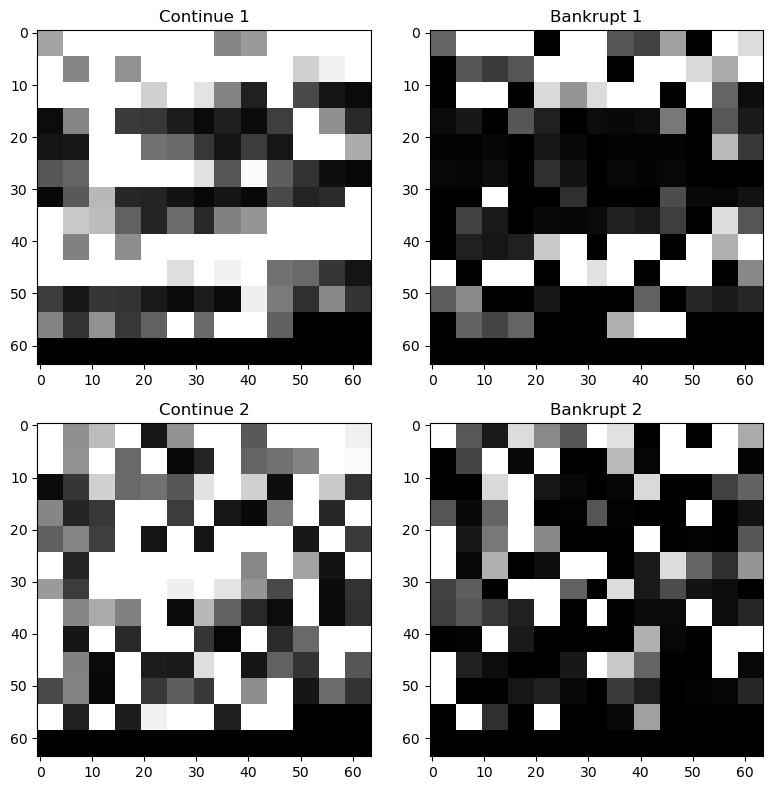

In [87]:
image_continue = array_to_image(data_continue)
image_continue_1 = enlarge_image(image_continue)
# fig1 = array_to_grayscale_image(enlarged_image)

image_bankrupt = array_to_image(data_bankrupt)
image_bankrupt_1 = enlarge_image(image_bankrupt)
# fig2 = array_to_grayscale_image(enlarged_image)

image_continue = rearrange_image(image_continue, pixels)
image_continue_2 = enlarge_image(image_continue)
# fig = array_to_grayscale_image(enlarged_image)

image_bankrupt = rearrange_image(image_bankrupt, pixels)
image_bankrupt_2 = enlarge_image(image_bankrupt)
# fig = array_to_grayscale_image(enlarged_image)

# Convert arrays to grayscale images
image_continue_1 = plt.cm.gray(image_continue_1)
image_continue_2 = plt.cm.gray(image_continue_2)
image_bankrupt_1 = plt.cm.gray(image_bankrupt_1)
image_bankrupt_2 = plt.cm.gray(image_bankrupt_2)

# Create a (2, 2) subplot grid
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Display the images in the subplots
axs[0, 0].imshow(image_continue_1)
axs[0, 0].set_title('Continue 1')

axs[1, 0].imshow(image_continue_2)
axs[1, 0].set_title('Continue 2')

axs[0, 1].imshow(image_bankrupt_1)
axs[0, 1].set_title('Bankrupt 1')

axs[1, 1].imshow(image_bankrupt_2)
axs[1, 1].set_title('Bankrupt 2')

# Adjust layout
plt.tight_layout()

test for modified create_dataset()

In [2]:
from create_dataset import create_dataset

DATAPATH = r'american_bankruptcy.csv'

bankrupt_data = load_data(DATAPATH)
dataset = create_dataset(bankrupt_data)

100%|██████████| 24221/24221 [00:18<00:00, 1286.66it/s]


In [ ]:
for i, (data, s) in enumerate(dataset[:5]):
    print("i:{}, status: {}".format(i, s))
    fig = array_to_grayscale_image(data.reshape(64, 64))
    plt.show()

### Oversample the dataset (as we have an extremely unbalanced dataset)

In [6]:
DATAPATH = r'american_bankruptcy.csv'
bankrupt_data = load_data(DATAPATH) # this load_data is the version before modification

100%|██████████| 8971/8971 [01:31<00:00, 98.46it/s] 


In [14]:
from collections import Counter
from imblearn.over_sampling import SMOTE

X, y = bankrupt_data.drop(columns=['company_name', 'year', 'status_label']), bankrupt_data['status_label'] 
# print(X.head())
print("Original dataset shape: %s", Counter(y))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print('Resampled dataset shape %s', Counter(y_res))

X_res['status_label'] = y_res
print(X_res['status_label'].describe())

Original dataset shape: %s Counter({1: 22453, 0: 1768})
Resampled dataset shape %s Counter({1: 22453, 0: 22453})
count    44906.000000
mean         0.500000
std          0.500006
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: status_label, dtype: float64
